# 限速节流
- 使用drf可以给网站api限速节流，比如一些爬虫在爬取你的网站，则可以通过设置访问的频率和次数来限制它 的行为

# 配置
- 限速节流配置也是分成两种，第一种是直接在settings.REST_FRAMEWORK中设置，第二种是针对每个视图函数进行设置，配置分成两个，一个是throttle_classes，另外一个是throttle_rates，前者是配置不同的节流方式，后者是配置节流的策略
        # settings.py
        REST_FRAMEWORK = {
            'DEFAULT_THROTTLE_CLASSES': [
                'rest_framework.throttling.AnonRateThrottle',
                'rest_framework.throttling.UserRateThrottle'
            ],
            'DEFAULT_THROTTLE_RATES': {
                'anon': '100/day',
                'user': '1000/day'
            }
        }

        # views.py
        from rest_framework.response import Response
        from rest_framework.throttling import UserRateThrottle
        from rest_framework.views import APIView

        class ExampleView(APIView):
            throttle_classes = [UserRateThrottle]

            def get(self, request, format=None):
                content = {
                    'status': 'request was permitted'
                }
                return Response(content)

# 节流的类
- 在drf中，节流的类总共有以下三个

## AnonRate Throttle
- 针对那些没有登录的用户进行节流，默认会根据REMOTE_ADDR,也就是用户的IP地址作为限制的标记，如果用户使用了透明代理（匿名代理无法追踪），那么在X-Forwarded-For中会保留所有的代理的ip，比如下图：
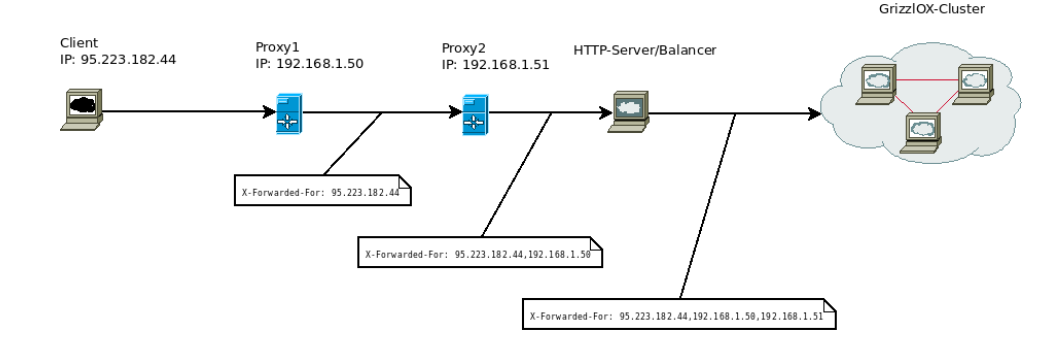
- 此时就要看在settingsREST_FRAMEWORK.NUM_PROXIES了，如果这个值设置的是0，那么将获取REMOTE_ADDR也就是真实的ip地址，如果设置的是大于0的数，那么将获取代理的最后一个ip

## UserRate Throttle
- 根据用户的id来作为节流的标识，可以通过两种设置方式设置节流的策略
    - 1.在settingsREST_FRAMEWORK.DEFAULT_THROTTLE_RATES'user']设置
    - 2.自定义节流类，继承自UserRateThrottle，然后重写rate属性
- 如果想要针对不同类型的用户实现不同策略的节流，可以通过继承UserRateThrottle类，然后设置scope属性，然后针对不同的scope设置不同的节流策略，比如针对管理员admin和普通用户normal，可以设置不同的策略
        class AdminRateThrottle(UserRateThrottle):
            scope = 'admin'

        class NormalRateThrottle(UserRateThrottle):
            scope = 'normal'
            
- 然后在settings.py中可以如下设置
        REST_FRAMEWORK = {
            'DEFAULT_THROTTLE_CLASSES': [
                'example.throttles.AdminRateThrottle',
                'example.throttles.NormalRateThrottle'
            ],
            'DEFAULT_THROTTLE_RATES': {
                'normal': '60/day',
                'admin': '1000/day'
            }
        }
        

## ScopedRate Throttle
- 这个就不管是登录用户，还是没有登录的用户，都是根据scope来实现节流策略的，这个就只需在视图中，重写throttle_scope属性，指定具体的scope，然后在settings.py中进行设置
        # views.py
        class ContactListView(APIView):
            throttle_scope = 'contacts'
            ...

        class UploadView(APIView):
            throttle_scope = 'uploads'
            ...

        # settings.py
        REST_FRAMEWORK = {
            'DEFAULT_THROTTLE_CLASSES': [
                'rest_framework.throttling.ScopedRateThrottle',
            ],
            'DEFAULT_THROTTLE_RATES': {
                'contacts': '1000/day',
                'uploads': '20/day'
            }
        }
- 关于节流的单位：'s', 'sec', 'm', 'min', 'h', 'hour', 'd', 'day'